# Multi-layer Bidirectional LSTM model

**OUTLINE:** In this project I've built LSTM architecture, where I've used two-layer bi-directional LSTM network.

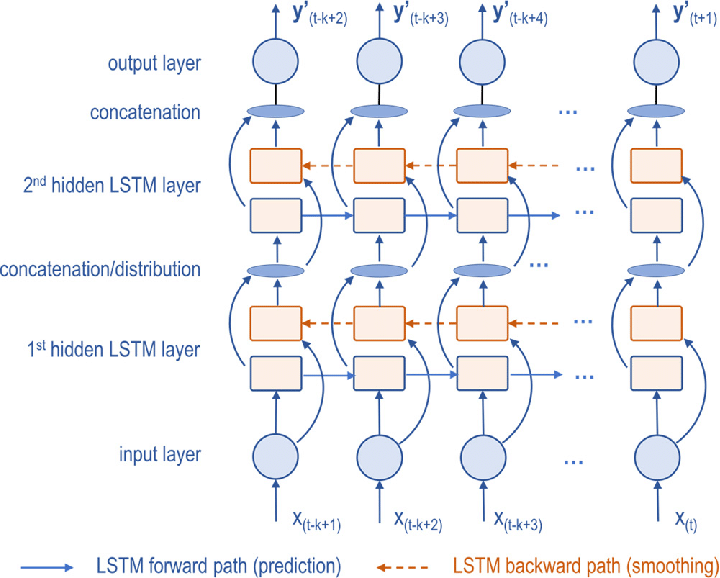

Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems.

In problems where all timesteps of the input sequence are available, Bidirectional LSTMs train two instead of one LSTMs on the input sequence. The first on the input sequence as-is and the second on a reversed copy of the input sequence. This can provide additional context to the network and result in faster and even fuller learning on the problem.

# Bidirectional LSTMs
The idea of Bidirectional Recurrent Neural Networks (RNNs) is straightforward.

It involves duplicating the first recurrent layer in the network so that there are now two layers side-by-side, then providing the input sequence as-is as input to the first layer and providing a reversed copy of the input sequence to the second.

In [ ]:
import tensorflow as tf                                        # tensorflow for modelling
import numpy as np                                             # numpy for math computations
import matplotlib.pyplot as plt                                # visualizations
import sklearn                                                 # scikit-learn
import cv2                                                     # image processing
from sklearn.metrics import confusion_matrix, roc_curve        # metrics
import seaborn as sns                                          # visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector
BATCH_SIZE=64

# Data Preparation

In [ ]:
# Download dataset and split into train, validation and test set.

train_ds,val_ds,test_ds=tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'],as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWYI89F/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWYI89F/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWYI89F/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# investigate few sample of validation set.
# Here in dataset, label 0= negative review & 1=positve review.

for review,label in val_ds.take(5):
  print(review)
  print(label)

tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
tf.Tensor(1, shape=(),

In [ ]:
def standardization(input_data):
    '''
    Input: raw reviews
    output: standardized reviews
    '''
    lowercase=tf.strings.lower(input_data)                                             # text will be lowercased.
    no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","")                            # regex expression for removing html tags.
    output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")    # all punctuation removed.

    return output

In [ ]:
standardization(tf.constant("<u>In the movie?, </u>man called Raj, went to a friend's pl**ce and they had a tensed discussion. I don't love this movie! would you?<br> <br /><br />T"))

<tf.Tensor: shape=(), dtype=string, numpy=b'in the movie man called raj went to a friends plce and they had a tensed discussion i dont love this movie would you t'>

In [ ]:
# config VOCAB_SIZE, SEQUENCE_LENGTH & EMBEDDING_DIM

VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

In [ ]:
# Tensorflow text Vectorization
# Here, arguments -
# max_tokens describes the maximum size of the vocabulary for this layer.
# standardize, whose role is literally to standardize the inputs text, where we could pass customize function, which should do standardization process. So we will be using our own function.
# output_sequence_length, signifies the maximum length of our different sentences.

vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [ ]:
# construct training data
training_data=train_ds.map(lambda x,y:x)  # input x and y and outputx

# create our vocabulary using tensorflow adapt method on our training_data set.
vectorize_layer.adapt(training_data)      # adapt the vectorize_layer to the training data

In [ ]:
# now we would like to check vectorized version of review & label, by passing it inot our vectorize_layer,
# which has been adapted on our full dataset, we will be able to convert this into numbers.

def vectorizer(review,label):
    return vectorize_layer(review),label

In [ ]:
# mapp dataset onto all, which is now vectorized.
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [ ]:
# Prefetching for more efficient loading of data.

train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Build model

In [ ]:
inputs=np.random.random([32, 10, 8]).astype(np.float32)
simple_rnn=tf.keras.layers.SimpleRNN(25)
output=simple_rnn(inputs)
print(output.shape)

(32, 25)


In [ ]:
EMBEDDING_DIM=64

# Build our model with tensorflow sequential model.
# In sequential models, we stack up multiple same/or different layers where one's output goes into another ahead.
# This is the default structure with neural nets. Dense is a layer type (fully connected layer).

EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(LSTM(64,return_sequences=True)),
    Bidirectional(LSTM(32)),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 64)           640000    
                                                                 
 bidirectional (Bidirectiona  (None, 250, 128)         66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [ ]:
# create checkpoint:
# here, each time we obatin validation accuracy higher than the current highest validation accuracy,
# we are going to save the model weights.

checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/lstm.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Configures the model for training:

# In ML, Loss function is used to find error or deviation in the learning process,
# we will be using Binary Cross entropy loss function, because our output can be either negative review 0 or positive review 1.

# Optimization is an important process which optimize the input weights by comparing the prediction and the loss function, we will be using Adam optimizer.
# Metrics is used to evaluate the performance of your model. It is similar to loss function, but not used in training process, for this we will use accuracy metric.

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
log_dir='logs/imdb/fit/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'/'

In [ ]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir,histogram_freq=1)

In [ ]:
# Train the model

# here, we are training the model with the given inputs=train_dataset and corresponding training labels= val_dataset.
# epochs − no of times the model is needed to be evaluated during training.

history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
391/391 [==============================] - 93s 208ms/step - loss: 0.6282 - accuracy: 0.6191 - val_loss: 0.4265 - val_accuracy: 0.8113
Epoch 2/10
391/391 [==============================] - 21s 54ms/step - loss: 0.3411 - accuracy: 0.8639 - val_loss: 0.3362 - val_accuracy: 0.8624
Epoch 3/10
391/391 [==============================] - 21s 54ms/step - loss: 0.2558 - accuracy: 0.9071 - val_loss: 0.3547 - val_accuracy: 0.8555
Epoch 4/10
391/391 [==============================] - 21s 54ms/step - loss: 0.2118 - accuracy: 0.9288 - val_loss: 0.3778 - val_accuracy: 0.8578
Epoch 5/10
391/391 [==============================] - 21s 53ms/step - loss: 0.1804 - accuracy: 0.9426 - val_loss: 0.4101 - val_accuracy: 0.8542
Epoch 6/10
391/391 [==============================] - 30s 78ms/step - loss: 0.1644 - accuracy: 0.9462 - val_loss: 0.4448 - val_accuracy: 0.8409
Epoch 7/10
391/391 [==============================] - 21s 53ms/step - loss: 0.1478 - accuracy: 0.9526 - val_loss: 0.4402 - val_accuracy

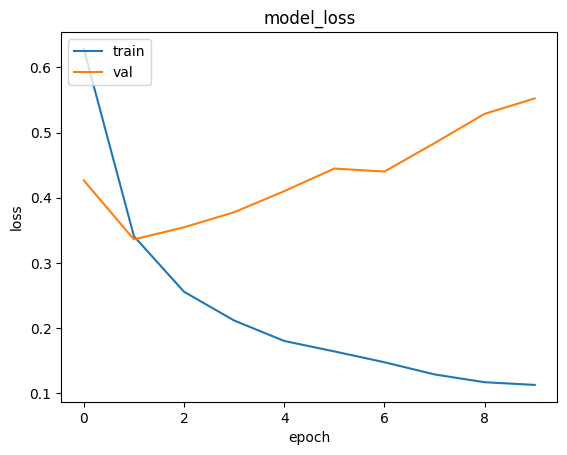

In [ ]:
# plot model loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

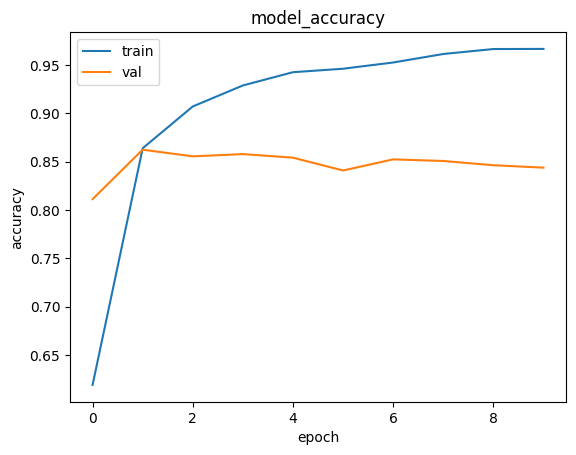

In [ ]:
# plot model accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Here, With the accuracy, one great change we could notice is that validation accuracy goes up to about 85% and training accuracy rises above 95%.

In RNN model, the best validation accuracy was 55%, So clearly this this model outperfroms the Simple_RNN and by very large margin.

# Model Evaluation

In [ ]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

391/391 [==============================] - 9s 23ms/step - loss: 0.0702 - accuracy: 0.9824


[0.07017643749713898, 0.9823600053787231]